In [10]:
!pip install yfinance pandas numpy scikit-learn matplotlib mplcursors xgboost ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c6d430eeb83782a0c863b344da0c57c4cdf5348d5b3ca1838e40f3e6a13be8c7
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import xgboost as xgb

In [25]:
# Ambil data saham
ticker = "BBRI.JK"
start_date = "2023-01-01"
end_date = "2025-05-10"
data = yf.download(ticker, start=start_date, end=end_date).dropna()

[*********************100%***********************]  1 of 1 completed


In [26]:
# Persiapan data
data.reset_index(inplace=True)
data['Day'] = (data['Date'] - data['Date'].min()).dt.days
data['Lag_1'] = data['Close'].shift(1)
data['Lag_3'] = data['Close'].shift(3)
data['MA_3'] = data['Close'].rolling(3).mean()
data['MA_7'] = data['Close'].rolling(7).mean()
data.dropna(inplace=True)

features = ['Day', 'Lag_1', 'Lag_3', 'MA_3', 'MA_7']
X = data[features]
X.columns = [col[0].strip() if isinstance(col, tuple) else col.strip() for col in X.columns]
y = data['Close']

In [27]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [28]:
# Latih model Random Forest & XGBoost
model_rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)
model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
# Evaluasi
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)

print("\nEvaluasi Random Forest:")
print(f"MAE  = {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"R²   = {r2_score(y_test, y_pred_rf):.4f}")

print("\nEvaluasi XGBoost:")
print(f"MAE  = {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R²   = {r2_score(y_test, y_pred_xgb):.4f}")


Evaluasi Random Forest:
MAE  = 117.72
RMSE = 156.60
R²   = 0.2507

Evaluasi XGBoost:
MAE  = 193.92
RMSE = 232.62
R²   = -0.6535


In [30]:
# Sliding window prediction (prediksi masa depan lebih realistis)
future_dates = []
future_preds_rf = []
future_preds_xgb = []
window_data = data.copy()

for i in range(1, 151):
    date = window_data['Date'].max() + timedelta(days=1)
    day = window_data['Day'].max() + 1

    lag_1 = window_data['Close'].iloc[-1]
    lag_3 = window_data['Close'].iloc[-3]
    ma_3 = window_data['Close'].iloc[-3:].mean()
    ma_7 = window_data['Close'].iloc[-7:].mean()

    row = pd.DataFrame([[day, lag_1, lag_3, ma_3, ma_7]], columns=features)
    row = row.astype(np.float32)

    pred_rf = model_rf.predict(row)[0]
    pred_xgb = model_xgb.predict(row)[0]

    # Simpan hasil dan tambahkan ke window data
    future_dates.append(date)
    future_preds_rf.append(pred_rf)
    future_preds_xgb.append(pred_xgb)

    new_row = pd.DataFrame({
        'Date': [date],
        'Day': [day],
        'Close': [pred_rf],
    })
    window_data = pd.concat([window_data, new_row], ignore_index=True)

<ipython-input-30-100229729>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row = row.astype(np.float32)


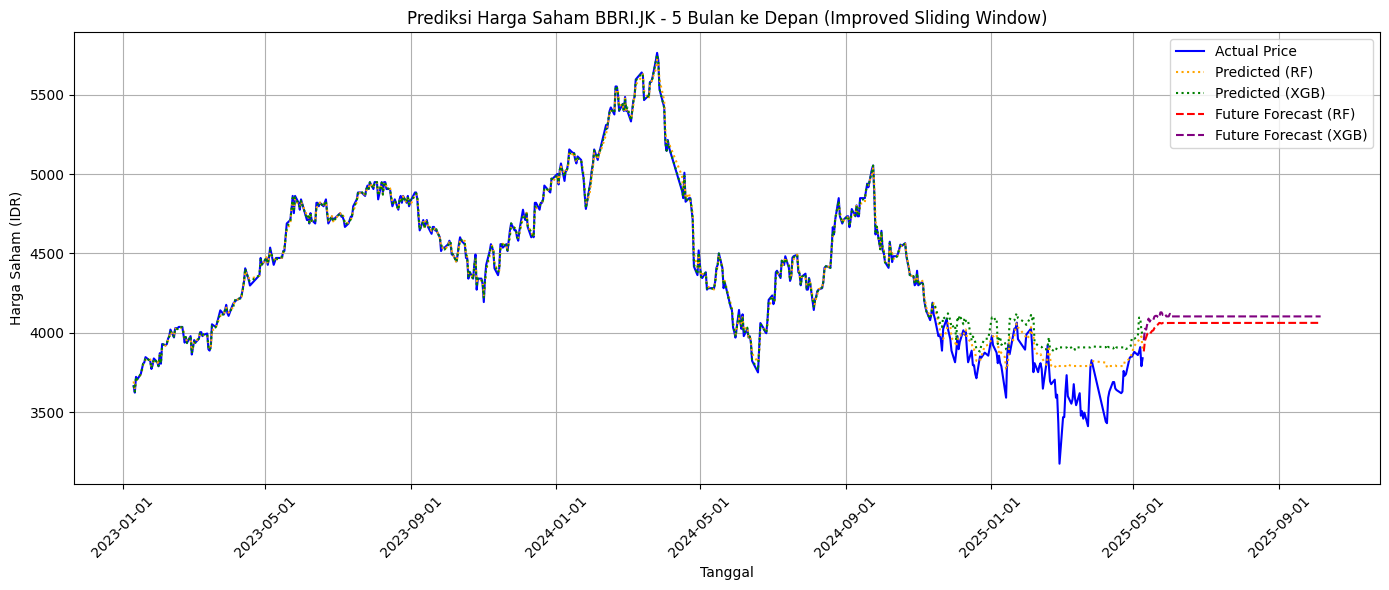

In [31]:
# Visualisasi
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Actual Price', color='blue')
plt.plot(data['Date'], model_rf.predict(X), label='Predicted (RF)', linestyle='dotted', color='orange')
plt.plot(data['Date'], model_xgb.predict(X), label='Predicted (XGB)', linestyle='dotted', color='green')
plt.plot(future_dates, future_preds_rf, label='Future Forecast (RF)', linestyle='dashed', color='red')
plt.plot(future_dates, future_preds_xgb, label='Future Forecast (XGB)', linestyle='dashed', color='purple')
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham (IDR)")
plt.title(f"Prediksi Harga Saham {ticker} - 5 Bulan ke Depan (Improved Sliding Window)")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
